In [35]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy.interpolate import griddata
from matplotlib.lines import Line2D
from datetime import datetime
from cartopy import crs as ccrs

In [111]:
def read_data(root_folder,csv_file):
    df = pd.read_csv(f'{root_folder}/csv/{csv_file}') 
    df = df[df['on_ground'] == False] #Excluding Taxiing Aircraft
    df['x_speed'] = np.sin(np.deg2rad(df['true_track']))*df['velocity']
    df['y_speed'] = np.cos(np.deg2rad(df['true_track']))*df['velocity']
    airspace_state = [(x,y,u,v,speed,country) for x,y,u,v,speed,country in zip(df['longitude'],df['latitude'],df['x_speed'],df['y_speed'],df['velocity'],df['origin_country'])]
    return airspace_state

In [3]:
# Config For Plotting Various Geolocations
plot_config = { 
    "regions" : {
        "eu": {
            "title":"EU Region",
            "set_extent":[-15,30,35,60],
            "headwidth":10,
            "headaxislength":7,
            "headlength":9,
            "width":0.001,
            "scale":20000,
            "x":0.9955,
            "y":0.0085
        },
        "us": {
            "title":"US Region",
            "set_extent":[-128,-65,22,52], 
            "headwidth":10,            
            "headaxislength":5,
            "headlength":8,
            "width":0.0025,
            "scale":35000,
            "x":0.9955,
            "y":0.0095
        }
    }
}
region_config = plot_config['regions']['us']

In [112]:
date_selection = '2024-04-28'
root_folder = f'{os.path.dirname(sys.path[0])}/data/get_states/{date_selection}'
file_list = []
for csv_file in os.listdir(f'{root_folder}/csv'):
    if '.csv' in csv_file:
        timestamp = csv_file.split('.')[0]
        file_list.append((timestamp,csv_file))
timestamp = file_list[1][0]
csv_file = file_list[1][1]
airspace_state = read_data(root_folder,csv_file)
print(airspace_state)

[(-77.2857, 42.9245, 67.90527560343463, 4.117577591446925, 68.03, 'United States'), (7.1948, 47.4927, -211.9515229110835, 12.332397807095662, 212.31, 'Switzerland'), (-102.1638, 32.4142, 14.400907522094842, -55.56414187711416, 57.4, 'United States'), (-86.1838, 35.3999, 31.38165891918629, -33.4414575561511, 45.86, 'United States'), (-75.425, -12.8708, 227.89369710284976, -52.48773590844412, 233.86, 'Chile'), (-82.1425, 31.7753, 107.00036048875675, 203.71925523935164, 230.11, 'United States'), (-118.3671, 33.939, -81.80035118812177, -10.798270486515253, 82.51, 'United States'), (17.1849, 59.1319, 6.68427928280692, 63.27793699599757, 63.63, 'Sweden'), (-97.5667, 33.7265, 47.32284994288696, -153.82532780164325, 160.94, 'United States'), (-114.3234, 36.3356, -122.945842360562, -97.23621931282518, 156.75, 'United States'), (79.8684, 27.1518, 184.6909470450352, -77.67485873568108, 200.36, 'India'), (140.2322, 35.0382, -136.3194531755588, -72.5433876098754, 154.42, 'Japan'), (-88.9326, 48.700

In [115]:
# Getting Sample Airspace States
airspace_state[1]
df = pd.DataFrame(airspace_state,columns=['x','y','u','v','speed','country'])

In [117]:
# Filtering Data To Desired Airspace Boundary
set_extent = [-128,-65,22,52]
filtered_airspace = df[(df['x']>=set_extent[0]) & (df['x']<=set_extent[1]) & (df['y']>=set_extent[2]) & (df['y']<=set_extent[3])]

In [118]:
# Zipping Filtered Aircraft Coordinates and Speeds
xy = list(zip(filtered_airspace['x'],filtered_airspace['y']))
u = filtered_airspace['u']
v = filtered_airspace['v']
speed = filtered_airspace['speed']

In [123]:
# Creating Regular Grid Intervals For the x and y Directions
grid_interval = 1
step_x = np.arange(set_extent[0],set_extent[1]+1,grid_interval)
step_y = np.arange(set_extent[2],set_extent[3]+1,grid_interval)

In [125]:
# Creating A Mesh Grid Based on the Intervals Created Earlier
grid_x,grid_y = np.meshgrid(step_x,step_y)

In [126]:
# Interpolating the speed values onto the Grid
u_grid = griddata(xy, u, (grid_x,grid_y), method='linear')
v_grid = griddata(xy, v, (grid_x,grid_y), method='linear')
speed_grid = griddata(xy, speed, (grid_x,grid_y), method='linear')
for grid_value in [u_grid,v_grid,speed_grid]:
    grid_value[np.isnan(grid_value)] = 0 # Replace NaN's with zero value

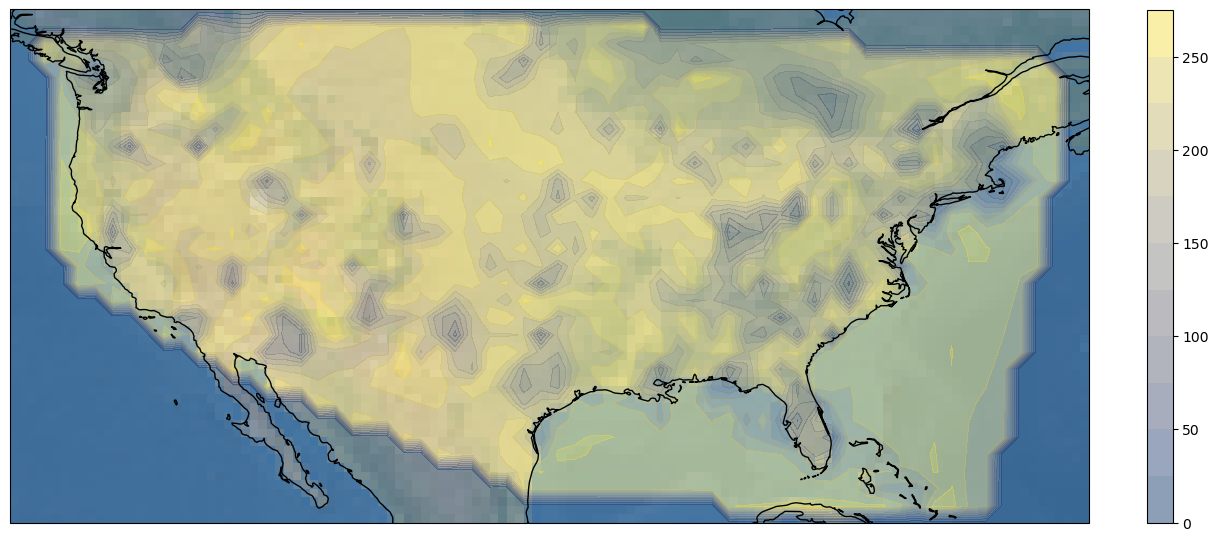

In [159]:
# fig, ax = plt.subplots(figsize =(15,9),num=1,clear=True,layout='constrained')
ax = plt.figure(figsize =(15,9),num=1,clear=True)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
im = ax.contourf(grid_x,grid_y,speed_grid,levels=12,alpha=0.45,cmap='cividis')
ax.set_extent(region_config.get('set_extent'), crs=ccrs.PlateCarree())
im_ratio = speed_grid.shape[0]/speed_grid.shape[1]*0.0455
plt.colorbar(im,fraction=im_ratio)